In [3]:
#PREP
import seaborn as sbn
import matplotlib.pyplot as plot
import scipy.stats as stats
import numpy as np
import pandas as pd
import math
from scipy.stats import t

In [4]:
#MASTER RECUIT DATABASE (ALL COLUMNS SHOWN)
recruit_db = pd.read_excel(r'C:\Users\jonat\OneDrive\Documents\Stats\CodeAcademy\Projects\ESPN 300 PROJECT\ESPN 150 Combined.xlsx')
print(recruit_db.head())

   Rank               Player  Class Pos     Hometown Home_State     Ht   Wt  \
0     3     Cameron Robinson   2014  OT  West Monroe         LA  6'5''  330   
1     6        Da'Shawn Hand   2014  DE   Woodbridge         VA  6'4''  262   
2     3          Eyabi Anoma   2018  DE    Baltimore         MD  6'6''  223   
3     5  Patrick Surtain Jr.   2018  CB   Plantation         FL  6'2''  192   
4     8           Tony Brown   2014  CB     Beaumont         TX  6'0''  196   

   Stars  Grade   School  
0      5     95  Alabama  
1      5     94  Alabama  
2      5     94  Alabama  
3      5     93  Alabama  
4      5     92  Alabama  


DATABASE BELOW SPANS 2011-2024. ET150, 5 STAR, 4 STAR COUNTS SPAN 2011-2024. THE REST OF THE COLUMNS COLLECT DATA FROM 2014-2024:
1. TOTAL ESPN T150 RECRUIT COMMITS
2. TOTAL 5 STAR COMMITS
3. TOTAL 4 STAR COMMITS
4. 80% OR BETTER WINNING SEASONS (CFP ERA
5. CONF. CHIP APPEARANCES
6. CONF. CHIP WINS
7. CFP BERTHS
8. CFP CHIP WINS

In [5]:
# MASTER SUCCESS DATABASE (ALL COLUMNS SHOWN)
success_db = pd.read_excel(r'C:\Users\jonat\OneDrive\Documents\Stats\CodeAcademy\Projects\ESPN 300 PROJECT\ESPN 150 School Dash.xlsx')
print(success_db.head())

       School  ET150_Count  5_Star_Count  4_Star_Count  \
0    Michigan           62             3            59   
1         LSU          106            10            96   
2     Clemson          101            13            88   
3  Ohio State          127            20           107   
4     Georgia          141            25           116   

   80_Percent_ Win_Seasons_2014-2024  Conference_Chip_App_Since_CFP_Era  \
0                                  7                                  2   
1                                  7                                  2   
2                                 11                                  8   
3                                 10                                  5   
4                                  9                                  7   

   Conference_Chip_Wins_CFP_Era  CFP_Berths  CFP_Chip_Wins  
0                             2           3              1  
1                             1           1              1  
2                

### FORMULA BUILD:
- WEIGHTED TALENT FACTOR (1.0 = 5 Star, 0.7 = 4 Star) / APPLIES TO 2011-2024 
- WEIGHTED MATURATION FACTOR (WMF) (1.0 = Sr/Jr, 0.9 = So, 0.7 = Fr) // APPLIES TO 2011-2024 
- WEIGHTED TALENT SCORE Current Year = YR-4(1.0 x WTF x Players/Class) + YR-3(1.0 x WTF x Players/Class)
YR-2(0.9 x WTF x Players/Class) + YR-1(0.7 x WTF x Players/Class) // ONLY APPLIES TO 2014-2024 

-----------------------------------------------------
### Section I) Weighted Talent Factor and Maturation

In [6]:
#1) Create dataframe/pivot for Team 5/4 star count per year
yearly_team_talent_df = (recruit_db[['Class','School','Stars']].groupby(['Class','School','Stars']).size().reset_index(name='count').\
                         pivot(index = ['Class','School'], columns = 'Stars', values = 'count').\
                         fillna(0).reset_index())
print(yearly_team_talent_df.head())

Stars  Class      School     4    5
0       2011     Alabama  10.0  1.0
1       2011    Arkansas   3.0  0.0
2       2011      Auburn   7.0  1.0
3       2011  California   5.0  0.0
4       2011     Clemson   5.0  2.0


In [7]:
#2) WEIGHTED TALENT FACTOR per YEAR per TEAM 

 # a) W.Talent Factor per year
five_star_weight = 1.0 
four_star_weight = 0.75

yearly_team_talent_df['Talent Factor'] = (\
yearly_team_talent_df[5] * five_star_weight +  #five star talent x five star weight
yearly_team_talent_df[4] * four_star_weight)    #four star talent x four star weight

 # b) New DF, Columns:
    # (Class, School, Talent Factor, Season, Mat weight) x 4 / next 3 years
    # i) Season Add, do a cross join to get DF w season
season_dic = {'Season': [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]}
season_df = pd.DataFrame(season_dic)
yearly_team_talent_PERseason = pd.merge(yearly_team_talent_df, season_df, how = 'cross')

    # ii) Filter for year + (0 -> 3) // Only include classes within 4 year window prior to season season 2014-2024
final_df = yearly_team_talent_PERseason[(yearly_team_talent_PERseason['Season']-\
                                         yearly_team_talent_PERseason['Class']).between(0,3)]

 # c) Maturation Weight added
    # i) Calculate year difference, to map maturation weights
final_df = final_df.copy().reset_index(drop=True)
final_df['Year Diff'] = final_df['Season'] - final_df['Class']

    # ii) create weight dictionary, then map to Season/Class year difference ('Year Diff')
weights = {0:0.7, 1:0.9, 2:1.0, 3:1.0} #maturation weights (0 = Freshman, 3 = Senior)
final_df['Maturation Weight'] = final_df['Year Diff'].map(weights)

print(final_df.head())

   Class      School     4    5  Talent Factor  Season  Year Diff  \
0   2011     Alabama  10.0  1.0           8.50    2014          3   
1   2011    Arkansas   3.0  0.0           2.25    2014          3   
2   2011      Auburn   7.0  1.0           6.25    2014          3   
3   2011  California   5.0  0.0           3.75    2014          3   
4   2011     Clemson   5.0  2.0           5.75    2014          3   

   Maturation Weight  
0                1.0  
1                1.0  
2                1.0  
3                1.0  
4                1.0  


----------------------------------------
### II) *CLASS* WEIGHTED TALENT SCORE (# OF PLAYERS x TALENT FACTOR x MATURATION WEIGHT)

In [8]:
#1) Make new column, multiply across rows
final_df['Weighted Talent Score'] = (final_df[4] + final_df[5]) * (final_df['Talent Factor']) * (final_df['Maturation Weight'])  
# 4 and 5 columns represent count of 4 and 5 star recruits x # Talent Factor x  Maturation Weight                             

print(final_df.head())

# final_df.to_excel('FINAL DATAFRAME.xlsx')

   Class      School     4    5  Talent Factor  Season  Year Diff  \
0   2011     Alabama  10.0  1.0           8.50    2014          3   
1   2011    Arkansas   3.0  0.0           2.25    2014          3   
2   2011      Auburn   7.0  1.0           6.25    2014          3   
3   2011  California   5.0  0.0           3.75    2014          3   
4   2011     Clemson   5.0  2.0           5.75    2014          3   

   Maturation Weight  Weighted Talent Score  
0                1.0                  93.50  
1                1.0                   6.75  
2                1.0                  50.00  
3                1.0                  18.75  
4                1.0                  40.25  


------------------------------------
### III) *SEASON* WEIGHTED TALENT SCORE (WTS) PER CFP YEAR, PER TEAM (SUM OF RECRUITING CLASS TALENT SCORES FROM PREVIOUS 4 CYCLES)
EX.  2014 *Season* WTS = WTS of 2011 *Class* + WTS of 2011 *Class* + WTS of 2011 *Class* + WTS of 2011 *Class*

In [9]:
#1) Group WTS by school, per season
CFP_yearly_WTS_by_team = (final_df.groupby(['School','Season'])\
['Weighted Talent Score'].sum().reset_index())
print(CFP_yearly_WTS_by_team)


        School  Season  Weighted Talent Score
0      Alabama    2014                462.300
1      Alabama    2015                535.825
2      Alabama    2016                540.850
3      Alabama    2017                528.875
4      Alabama    2018                481.850
..         ...     ...                    ...
610  Wisconsin    2020                  7.425
611  Wisconsin    2021                  9.600
612  Wisconsin    2022                 10.950
613  Wisconsin    2023                  8.175
614  Wisconsin    2024                  2.025

[615 rows x 3 columns]


### IV) CORRELATION SETUP
(Didn't have success metrics by year, only had frequency, so had to use  WTS average for analysis)

In [22]:
#1) ANOTHER...dataframe. For average Season WTS
CFP_avg_WTS_by_team = (final_df.groupby(['School'])\
['Weighted Talent Score'].mean())
avg_WTS = pd.DataFrame(CFP_avg_WTS_by_team).reset_index()
print(avg_WTS.head())
avg_WTS.to_excel('AVG WTS.xlsx')

       School  Weighted Talent Score
0     Alabama             145.119318
1     Arizona               1.404545
2  Arizona St               1.159091
3    Arkansas               3.343548
4      Auburn              23.602381


In [23]:
#2) Add to success DF
correlation_df = pd.merge(avg_WTS, success_db, on = 'School', how = 'left')
print(correlation_df.head())
correlation_df.to_excel('coreelation.xlsx')

       School  Weighted Talent Score  ET150_Count  5_Star_Count  4_Star_Count  \
0     Alabama             145.119318        194.0          33.0         161.0   
1     Arizona               1.404545          4.0           0.0           4.0   
2  Arizona St               1.159091         11.0           0.0          11.0   
3    Arkansas               3.343548         20.0           0.0          20.0   
4      Auburn              23.602381         70.0           7.0          63.0   

   80_Percent_ Win_Seasons_2014-2024  Conference_Chip_App_Since_CFP_Era  \
0                               11.0                                7.0   
1                                2.0                                1.0   
2                                2.0                                1.0   
3                                1.0                                0.0   
4                                2.0                                1.0   

   Conference_Chip_Wins_CFP_Era  CFP_Berths  CFP_Chip_Wins  
0

------------------------
### V) CORRELATE AVG SEASON WTS TO SUCCESS METRICS

In [12]:
#1) Drop all columns except WTS and success metrics
correlation_df2 = correlation_df.copy()
correlations = correlation_df2.drop(columns = ['Weighted Talent Score','School','ET150_Count','5_Star_Count','4_Star_Count'])\
.corrwith(correlation_df2['Weighted Talent Score'])
# print(correlations)

#2) Tidy
correlations_results = correlations.copy()
correlations_results_df = correlations_results.reset_index()
correlations_results_df.columns = ['Stat','Correlation']
print(correlations_results_df)

                                Stat  Correlation
0  80_Percent_ Win_Seasons_2014-2024     0.596077
1  Conference_Chip_App_Since_CFP_Era     0.557501
2       Conference_Chip_Wins_CFP_Era     0.631791
3                         CFP_Berths     0.803782
4                      CFP_Chip_Wins     0.862081


--------------------------------
### VI) STASTICAL SIGNIGFICANCE

In [13]:
#1) t test to see significance
pvalues = []

for corr in correlations_results_df['Correlation']:
    r = corr                                                # correlation coefficients
    n = 73                                                  # teams examined
    tstat = r * math.sqrt((n - 2) / (1 - r ** 2))           # T-stat
    dfree = n - 2                                           # degree of freedom
    p = 2 * (1 - t.cdf(abs(tstat), dfree))                  # P value 
    pvalues.append(p)

correlations_results_df['P Value'] = pvalues
correlations_results_df = correlations_results_df.copy()
sorted_cm_df = correlations_results_df.reset_index(drop = True)
sorted_cm_df = correlations_results_df.sort_values(by = 'P Value', ascending = True)
print(sorted_cm_df) #all stats below shown to be significant at 5% level

                                Stat  Correlation       P Value
3                         CFP_Berths     0.803782  0.000000e+00
4                      CFP_Chip_Wins     0.862081  0.000000e+00
2       Conference_Chip_Wins_CFP_Era     0.631791  2.049229e-09
0  80_Percent_ Win_Seasons_2014-2024     0.596077  2.637946e-08
1  Conference_Chip_App_Since_CFP_Era     0.557501  3.001166e-07


-------------------------------
### VII) DATA VIZ

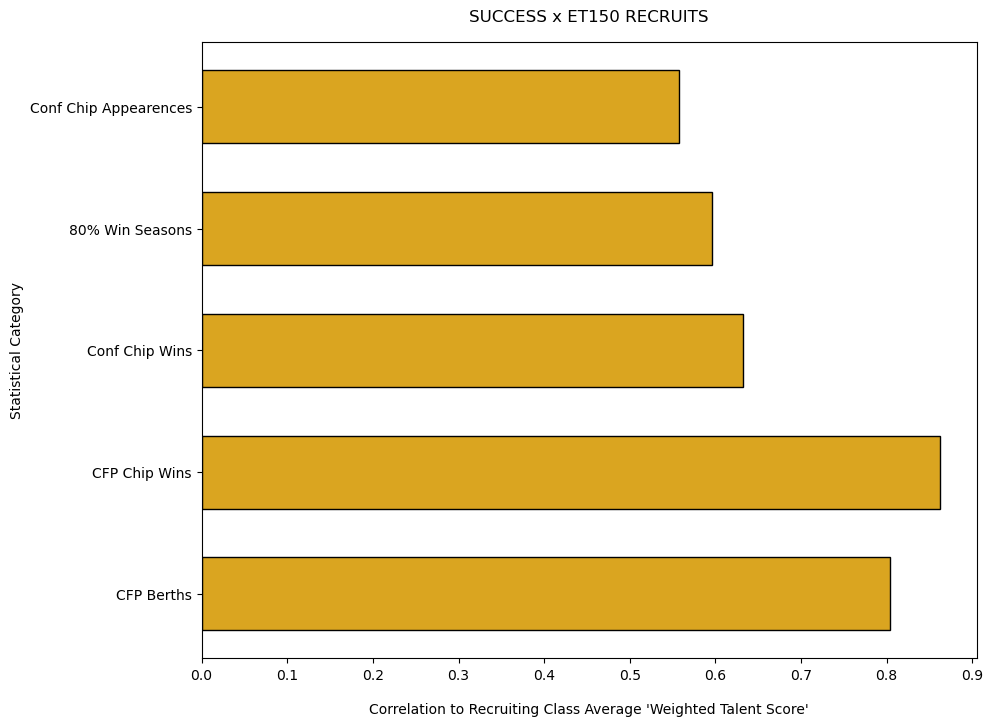

In [14]:
#VII Data Viz 

#1) CORRELATION CHART
plot.figure(figsize = (10,8))
plot.barh(sorted_cm_df['Stat'], sorted_cm_df['Correlation'],height = 0.6, color = 'goldenrod',edgecolor='black' )
plot.xticks(np.arange(0.0,1.0,0.1))
plot.yticks(ticks = range(len(sorted_cm_df['Stat'])),\
             labels = ['CFP Berths','CFP Chip Wins',
                       'Conf Chip Wins','80% Win Seasons',
                       'Conf Chip Appearences'])
plot.xlabel("Correlation to Recruiting Class Average 'Weighted Talent Score'",labelpad=15)
plot.ylabel('Statistical Category')
plot.title('SUCCESS x ET150 RECRUITS', pad=15)
plot.show()
plot.close()

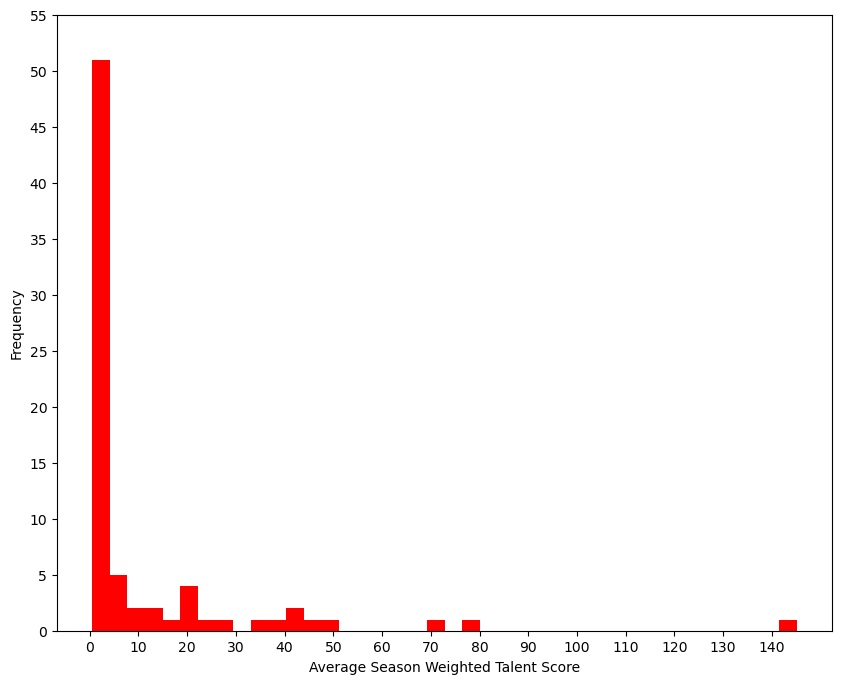

In [15]:
#VII Data Viz

#2) WTS TOTALS (from 2014-2024)
plot.figure(figsize = (10,8))
plot.hist(correlation_df['Weighted Talent Score'], bins = 40, color = 'red')
plot.xticks(np.arange(0.0,150,10))
plot.xlabel('Average Season Weighted Talent Score')
plot.yticks(np.arange(0.0,60,5))
plot.ylabel('Frequency')
plot.show()

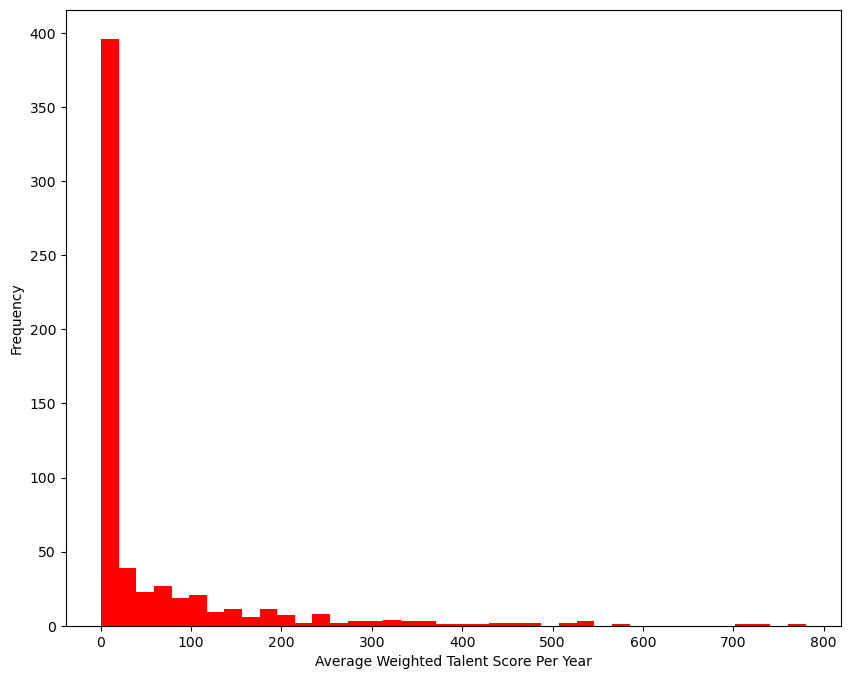

In [21]:
#VII Data Viz

#3) WTS Year over Year (from 2014-2024)
plot.figure(figsize = (10,8))
plot.hist(CFP_yearly_WTS_by_team['Weighted Talent Score'], bins = 40, color = 'red')
# plot.xticks(np.arange(0.0,150,10))
plot.xlabel('Average Weighted Talent Score Per Year')
# plot.yticks(np.arange(0.0,400,50))
plot.ylabel('Frequency')
plot.show()
plot.close()

# BREAK // BREAK // BREAK // BREAK // EXTRA BELOW

In [17]:
#AVERAGE GRADE/RECRUIT (RECRUIT DATABASE)
average_grade = recruit_db.groupby('School').Grade.mean().reset_index()
print(round(average_grade,2))

           School  Grade
0         Alabama  85.62
1         Arizona  83.00
2      Arizona St  84.55
3        Arkansas  83.60
4          Auburn  84.61
..            ...    ...
71       Virginia  83.67
72  Virginia Tech  84.22
73     W Virginia  82.57
74     Washington  84.43
75      Wisconsin  84.60

[76 rows x 2 columns]


In [18]:
#MODE GRADE PER TEAM (RECRUIT DATABASE)
mode_grade = recruit_db.groupby('School').Grade.agg(pd.Series.mode).reset_index()
print(round(mode_grade,2))

           School Grade
0         Alabama    84
1         Arizona    83
2      Arizona St    84
3        Arkansas    83
4          Auburn    84
..            ...   ...
71       Virginia    80
72  Virginia Tech    84
73     W Virginia    83
74     Washington    84
75      Wisconsin    83

[76 rows x 2 columns]


In [19]:
#MEDIAN GRADE PER TEAM (RECRUIT DATABASE)
median_grade = recruit_db.groupby('School').Grade.median().reset_index()
print(round(median_grade,2))

           School  Grade
0         Alabama   85.0
1         Arizona   83.0
2      Arizona St   84.0
3        Arkansas   83.5
4          Auburn   84.0
..            ...    ...
71       Virginia   82.5
72  Virginia Tech   84.0
73     W Virginia   83.0
74     Washington   84.0
75      Wisconsin   83.5

[76 rows x 2 columns]


# COME BACK AND FIX LATER BELOW

In [20]:
# #CORRELATE MEAN GRADE TO SUCCESS
# success_db_v2 = success_db[['80_Percent_ Win_Seasons_2014-2024', 'Conference_Chip_App_Since_CFP_Era' ,'Conference_Chip_Wins_CFP_Era', 'CFP_Berths', 'CFP_Chip_Wins']]
# outcome = average_grade.Grade

# for col in success_db_v2:
#     r = success_db_v2[col].corr(outcome)
#     print(f"{col} vs mean:", round(r,4))

# print("\n")

# #CORRELATE MODE GRADE TO SUCCESS
# outcome = mode_grade.Grade

# for col in success_db_v2:
#     r = success_db_v2[col].corr(outcome)
#     print(f"{col} vs mode:", round(r,4))

# print("\n")

# #CORRELATE MEDIAN GRADE TO SUCCESS
# outcome = median_grade.Grade

# for col in success_db_v2:
#     r = success_db_v2[col].corr(outcome)
#     print(f"{col} vs median:", round(r,4))